### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

In [1]:
import pandas as pd

LABEL_FEATURE = "tot_sales"

indicators = pd.read_csv('../dataset/indicators_no_outlier.csv', index_col="CustomerID")

In [2]:
indicators.describe()

,Entropy,i,iu,imax,tot_sales,mean_sales
count,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000
mean,0.883279,761.545781,54.277552,209.982070,215.797343,62.086895
std,0.833093,1151.855864,56.299433,198.147531,272.329634,48.291224
min,-0.000000,1.000000,1.000000,1.000000,0.170000,0.170000
25%,-0.000000,153.000000,15.000000,80.000000,49.965000,27.682500
50%,0.693147,356.000000,34.000000,150.000000,118.950000,49.785000
75%,1.386294,886.500000,74.000000,268.000000,266.235000,84.280000
max,3.550250,13162.000000,315.000000,1440.000000,2464.840000,318.190000


### Computing spending profile label

we begin by plotting the distribution and the quantiles for tot_sales, the feature from which we want to compute our label

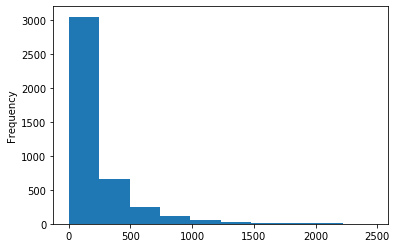

In [3]:
df = indicators[LABEL_FEATURE]
df.plot.hist()

In [4]:
quantiles = []
for i in range(0, 100, 5):
    quantile = df.quantile(i/100)
    quantiles.append(quantile)
    print(f"{i}% quantile: ".format(i)+str(round(quantile, 2)))

0% quantile: 0.17
5% quantile: 11.31
10% quantile: 19.85
15% quantile: 29.82
20% quantile: 39.27
25% quantile: 49.97
30% quantile: 61.46
35% quantile: 73.5
40% quantile: 88.38
45% quantile: 101.34
50% quantile: 118.95
55% quantile: 140.37
60% quantile: 164.38
65% quantile: 191.79
70% quantile: 223.34
75% quantile: 266.24
80% quantile: 317.61
85% quantile: 402.86
90% quantile: 537.88
95% quantile: 769.93


In [5]:
def calc_profile(tot_sales, quantiles):
    if (tot_sales < quantiles[10]):
        return "low"
    elif (tot_sales < quantiles[15]):
        return "medium"
    else:
        return "high"

indicators["spending_profile"] = indicators[LABEL_FEATURE].apply(lambda x : calc_profile(x, quantiles))

We drop the column we used to compute our label in order to proceed with classification

In [6]:
indicators = indicators.drop(LABEL_FEATURE, axis=1)

In [7]:
indicators.head()

,Entropy,i,iu,imax,mean_sales,spending_profile
CustomerID,,,,,,
12347,1.945910,2458,103,319,68.744286,high
12348,1.386294,2341,22,1254,44.677500,medium
12350,-0.000000,197,17,197,65.300000,low
12352,2.079442,473,59,98,167.177500,high
12353,-0.000000,20,4,20,24.300000,low


### Discretizing the label

#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

adult = discretize_data(adult, variables)

## Classification with Decision Tree

In [8]:
df = indicators.copy(deep=True)
print(df)

             Entropy     i   iu  imax  mean_sales spending_profile
CustomerID                                                        
12347       1.945910  2458  103   319   68.744286             high
12348       1.386294  2341   22  1254   44.677500           medium
12350      -0.000000   197   17   197   65.300000              low
12352       2.079442   473   59    98  167.177500             high
12353      -0.000000    20    4    20   24.300000              low
...              ...   ...  ...   ...         ...              ...
18280      -0.000000    45   10    45   47.650000              low
18281      -0.000000    54    7    54   39.360000              low
18282       0.693147   103   12    75   31.195000              low
18283       2.566599  1357  263    61   73.395625             high
18287       1.098612  1586   59   488   34.850000              low

[4183 rows x 6 columns]


In [9]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = df.pop('spending_profile')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify =label, test_size=0.5)

In [10]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

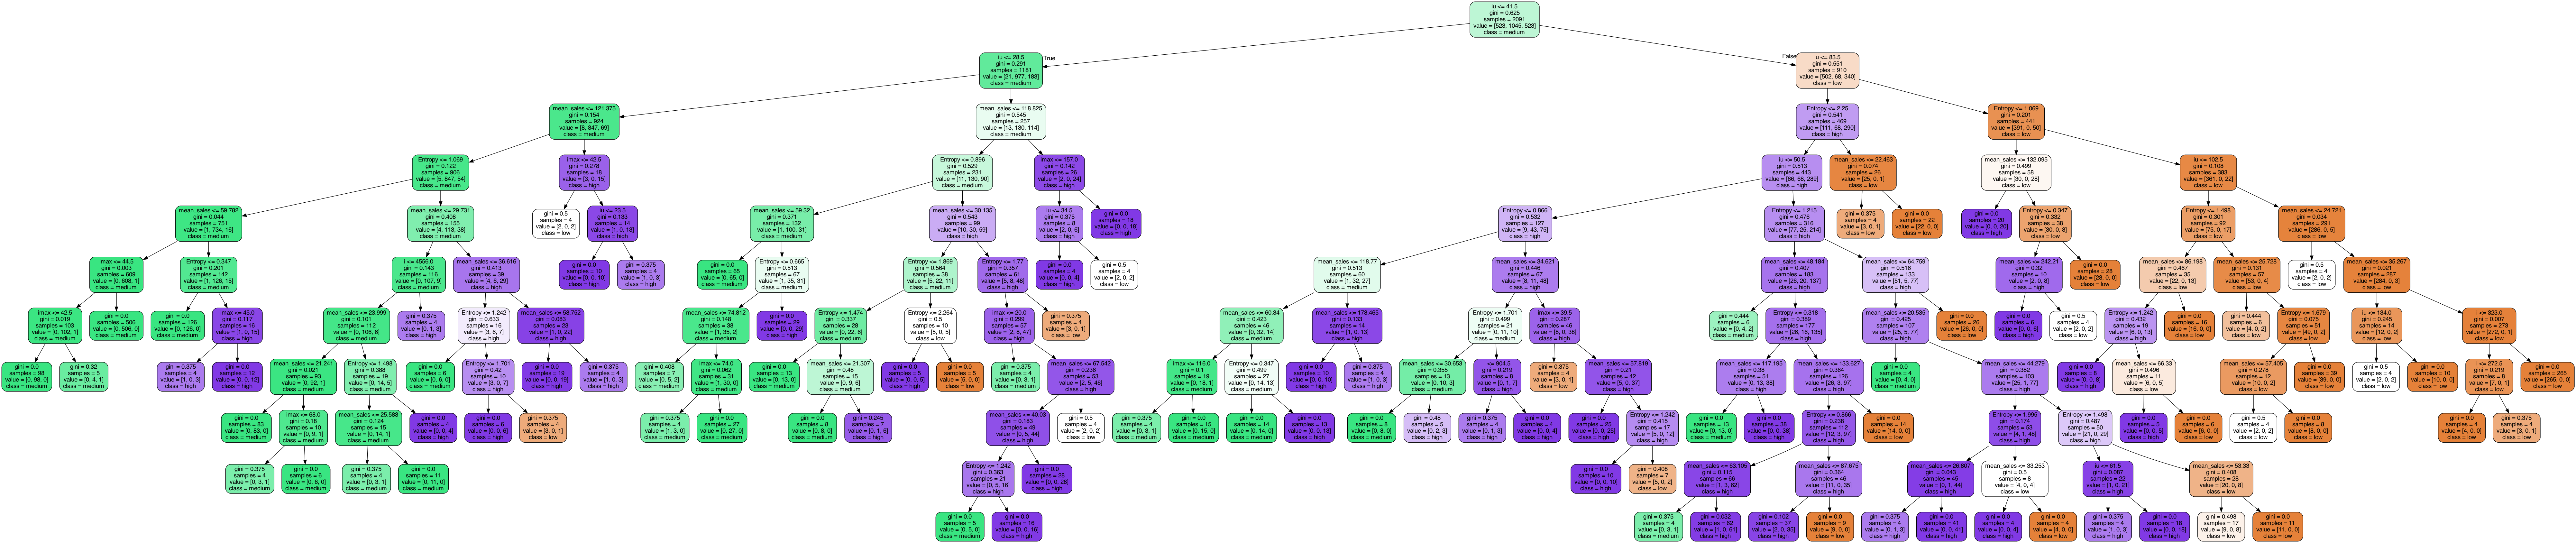

In [11]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'medium', "high"],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [12]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Decision Tree evaluation

In [13]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.973218555714969
Accuracy test set  0.9349904397705545
Precision train set  0.9734775993902326
Recall train set  0.973218555714969
F1 score train set  0.9730768129460814
Support train set  (array([0.94311927, 0.98952381, 0.97177419]), array([0.98279159, 0.99425837, 0.92160612]), array([0.96254682, 0.99188544, 0.94602552]), array([ 523, 1045,  523]))


In [14]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=["low", "medium", "high"]))

In [15]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

         low       0.88      0.95      0.91       523
      medium       0.98      0.98      0.98      1046
        high       0.91      0.83      0.87       523

    accuracy                           0.93      2092
   macro avg       0.92      0.92      0.92      2092
weighted avg       0.94      0.93      0.93      2092



In [16]:
#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.023740688959757488
Score time  0.006706078847249349
Test score  0.9253945480631277
Train score  0.967479674796748


In [17]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[ 495,    2,   26],
       [   2, 1027,   17],
       [  65,   24,  434]])

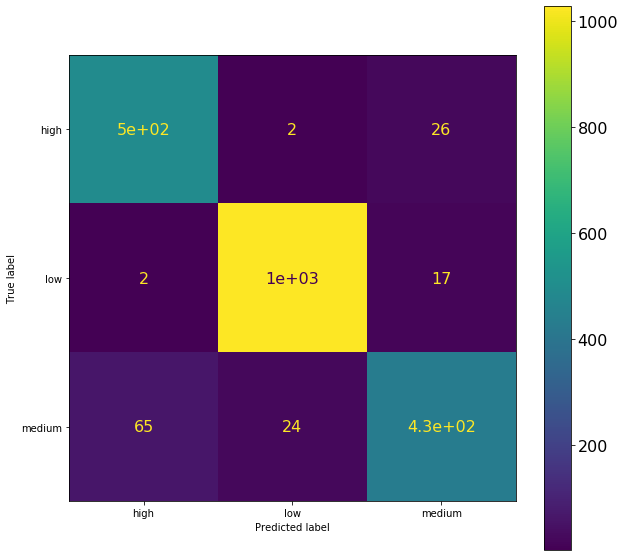

In [18]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16, "axes.labelsize" : 14})


plot_confusion_matrix(dt, test_set, test_label, ax=ax)
plt.show() 

## Classification with Naive Bayes

In [19]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [20]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

         low       0.87      0.74      0.80       523
      medium       0.91      0.92      0.91      1046
        high       0.64      0.72      0.68       523

    accuracy                           0.82      2092
   macro avg       0.81      0.79      0.80      2092
weighted avg       0.83      0.82      0.83      2092



## Classification with Random Forest

In [21]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=3,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [22]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [23]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

         low       0.88      0.81      0.85       523
      medium       0.95      0.94      0.95      1046
        high       0.74      0.80      0.77       523

    accuracy                           0.88      2092
   macro avg       0.86      0.85      0.85      2092
weighted avg       0.88      0.88      0.88      2092



### Volendo il random forest può essere "migliorato" e tunato in vari modi. Ne vale la pena? Forse no. Guarda il notebook adult_classification

## Classification with KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [25]:
#prediction on the test test
test_pred_knn = knn.predict(test_set)

In [26]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

         low       0.71      0.88      0.79       523
      medium       0.85      0.94      0.89      1046
        high       0.73      0.40      0.52       523

    accuracy                           0.79      2092
   macro avg       0.76      0.74      0.73      2092
weighted avg       0.78      0.79      0.77      2092



## Classification with SVM

In [27]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
svm.fit(train_set, train_label)

SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [28]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [29]:
test_pred_svm = svm.predict(test_set)

In [30]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=["low", "medium", "high"]))

              precision    recall  f1-score   support

         low       0.67      0.59      0.63       523
      medium       0.67      0.91      0.77      1046
        high       0.35      0.15      0.21       523

    accuracy                           0.64      2092
   macro avg       0.57      0.55      0.54      2092
weighted avg       0.59      0.64      0.60      2092



## Classification with Rule based

In [34]:
#we run a grid search to find the best configuration of parameters' values
"""from sklearn.model_selection import GridSearchCV
import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label)"""

'from sklearn.model_selection import GridSearchCV\nimport wittgenstein as lw\nripper = lw.RIPPER()\nparam_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}\ngrid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)\ngrid_search.fit(train_set, train_label)'

### Rule based non funziona perché non abbiamo una label numerica -> dovremmo convertirla a int

## Classification with Neural Network

In [152]:
df = indicators.copy(deep=True)
print(df)

             Entropy     i   iu  imax  mean_sales spending_profile
CustomerID                                                        
12347       1.945910  2458  103   319   68.744286             high
12348       1.386294  2341   22  1254   44.677500           medium
12350      -0.000000   197   17   197   65.300000              low
12352       2.079442   473   59    98  167.177500             high
12353      -0.000000    20    4    20   24.300000              low
...              ...   ...  ...   ...         ...              ...
18280      -0.000000    45   10    45   47.650000              low
18281      -0.000000    54    7    54   39.360000              low
18282       0.693147   103   12    75   31.195000              low
18283       2.566599  1357  263    61   73.395625             high
18287       1.098612  1586   59   488   34.850000              low

[4183 rows x 6 columns]


In [153]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [154]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ["spending_profile"]
df = discretize_data(df, variables)
df = df.drop("spending_profile", axis=1)

In [155]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = df.pop('spending_profile_num')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify =label, test_size=0.5)

In [156]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 5)),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='sigmoid')
])
model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [157]:
import numpy as np
y_train = np.asarray(train_label).astype('int').reshape((-1,1))
history = model.fit(train_set, y_train,
                    epochs=80,
                    batch_size=512,
                    validation_split=0.2)

Epoch 1/80
4/4 [==============================] - 2s 167ms/step - loss: 0.7661 - accuracy: 0.4800 - val_loss: 0.5898 - val_accuracy: 0.5251
Epoch 2/80
4/4 [==============================] - 0s 36ms/step - loss: 0.6177 - accuracy: 0.4802 - val_loss: 0.5118 - val_accuracy: 0.5251
Epoch 3/80
4/4 [==============================] - 0s 33ms/step - loss: 0.5430 - accuracy: 0.4545 - val_loss: 0.4900 - val_accuracy: 0.5251
Epoch 4/80
4/4 [==============================] - 0s 72ms/step - loss: 0.5291 - accuracy: 0.3884 - val_loss: 0.4828 - val_accuracy: 0.2053
Epoch 5/80
4/4 [==============================] - 0s 67ms/step - loss: 0.5254 - accuracy: 0.3548 - val_loss: 0.4797 - val_accuracy: 0.2387
Epoch 6/80
4/4 [==============================] - 0s 36ms/step - loss: 0.5113 - accuracy: 0.3535 - val_loss: 0.4781 - val_accuracy: 0.2387
Epoch 7/80
4/4 [==============================] - 0s 62ms/step - loss: 0.5183 - accuracy: 0.3431 - val_loss: 0.4771 - val_accuracy: 0.2387
Epoch 8/80
4/4 [==========

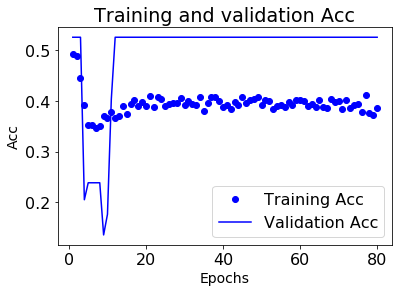

In [158]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [159]:
test_pred_nn = model.predict_classes(test_set)

/Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [160]:
# test_pred_nn

In [161]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

         low       0.00      0.00      0.00       523
      medium       0.50      1.00      0.67      1046
        high       0.00      0.00      0.00       523

    accuracy                           0.50      2092
   macro avg       0.17      0.33      0.22      2092
weighted avg       0.25      0.50      0.33      2092



/Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Per qualche ragione il neural network butta in output solo due label
Qua sotto altro neural network

In [175]:
model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(1, 13)),
  tf.keras.layers.Dense(128, input_dim=5, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [176]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 128)               768       
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_55 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)               

In [ ]:
train_set.values.shape

In [172]:
import numpy as np
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
history = model.fit(train_set.values, y_train,
                    epochs=80,
                    batch_size=512,
                   validation_split=0.2)

Epoch 1/80


ValueError: in user code:

    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


In [ ]:
test_pred_nn = model.predict_classes(test_set)
report_scores(test_label, test_pred_nn)

### Questo va un po' meglio, ma non predice high, boh!